In [5]:
import kagglehub
base_directory = kagglehub.dataset_download('gunavenkatdoddi/eye-diseases-classification')
print('Data source import complete.')

Data source import complete.


In [6]:
# utils
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# torch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Config
target_size = (224, 224)
random_state = 42
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# Class labels
categories = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
label_map = {
    'cataract': 0,
    'diabetic_retinopathy': 1,
    'glaucoma': 2,
    'normal': 3
}

In [8]:
# Function to create dataframe from folder structure
def create_dataset(path):
    my_list = []
    for category in categories:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [10]:
import os

print("Base directory:", base_directory)
print("Contents:")
print(os.listdir(base_directory))

Base directory: /kaggle/input/eye-diseases-classification
Contents:
['dataset']


In [11]:
# Corrected path to match actual dataset location
dataset_path = os.path.join(base_directory, 'dataset')
full_df = create_dataset(dataset_path)
full_df['label'] = full_df['label'].map(label_map)

In [12]:
# Split into train (70%), val (15%), test (15%)
train_df, temp_df = train_test_split(full_df, test_size=0.3, stratify=full_df['label'], random_state=random_state)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=random_state)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [13]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [14]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [15]:
# Create Dataset objects
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df, transform=test_transform)
test_dataset = ImageDataset(test_df, transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [21]:
def display_images_from_df(df, num_images=8, image_size=(224, 224), title=''):
    import matplotlib.pyplot as plt
    import random
    from PIL import Image

    sample_df = df.sample(n=num_images).reset_index(drop=True)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))

    for i in range(num_images):
        image_path = sample_df.loc[i, 'file_path']
        label = sample_df.loc[i, 'label']
        label_name = [k for k, v in label_map.items() if v == label][0]

        image = Image.open(image_path).resize(image_size)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(label_name, fontsize=9)

    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

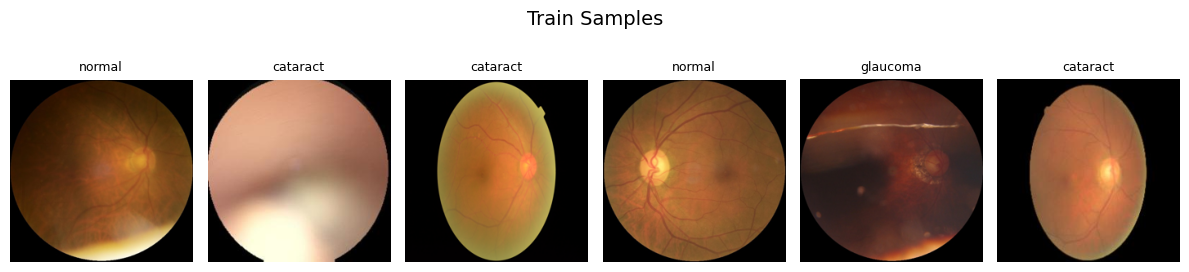

In [22]:
display_images_from_df(train_df, num_images=6, title='Train Samples')

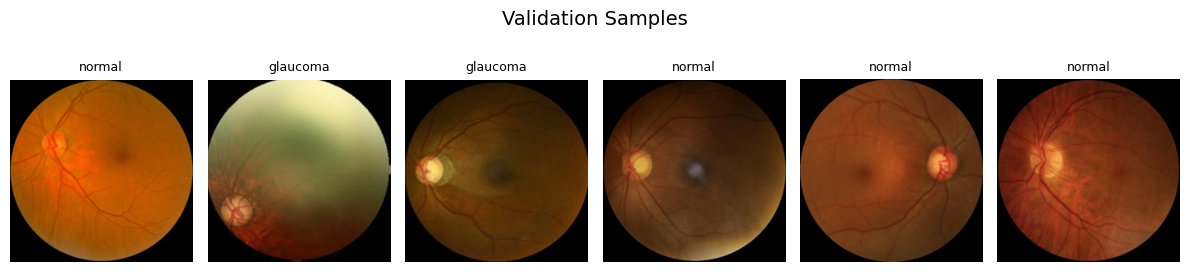

In [23]:
display_images_from_df(val_df, num_images=6, title='Validation Samples')


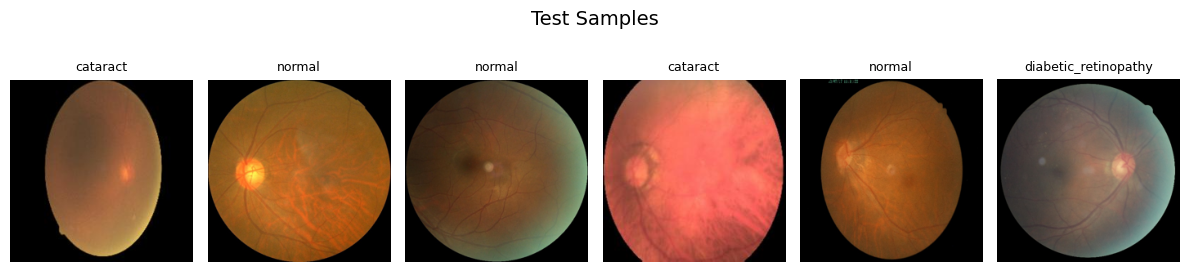

In [24]:
display_images_from_df(test_df, num_images=6, title='Test Samples')

In [25]:
def plot_class_distribution_from_df(df, title=''):

    # Count labels
    label_counts = df['label'].value_counts().sort_index()
    labels = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]
    counts = [label_counts.get(i, 0) for i in range(len(labels))]

    plt.bar(labels, counts, color=['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{title} Set Distribution")
    plt.show()


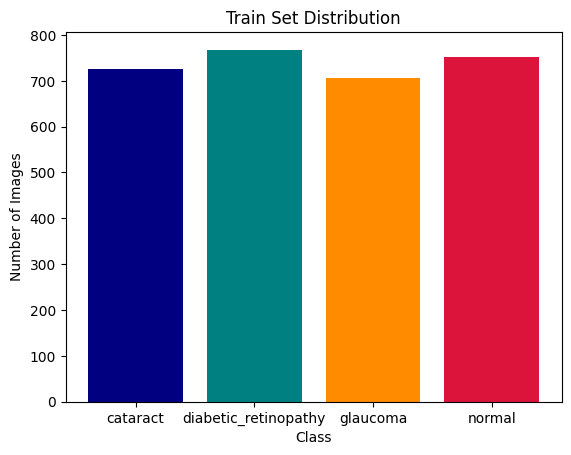

In [26]:
plot_class_distribution_from_df(train_df, title='Train')

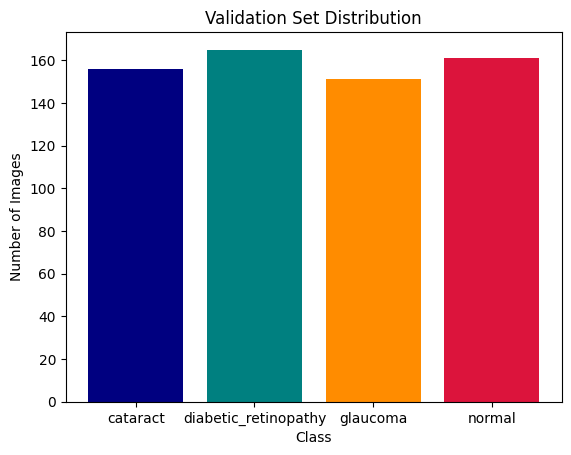

In [27]:
plot_class_distribution_from_df(val_df, title='Validation')


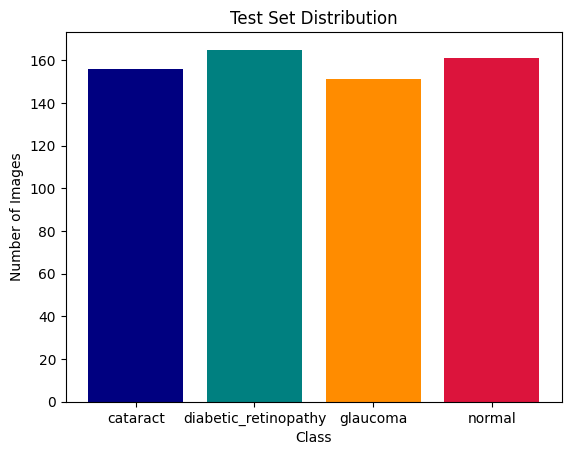

In [28]:
plot_class_distribution_from_df(test_df, title='Test')

#Load The Model

In [29]:
# Load pretrained ResNet-18 model
model2 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [30]:
# Freeze all layers except the final fully connected layer
for param in model2.parameters():
    param.requires_grad = False

In [31]:
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

In [32]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)
print(f"Model is being trained on: {device}")  # Check where the model is located

Model is being trained on: cuda


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.fc.parameters(), lr=0.001)

# Checking Cuda

In [34]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU name:", torch.cuda.get_device_name(0))

Using device: cuda
GPU name: Tesla T4


In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the device (before starting training)
    print("Using device:", device)
    if device.type == 'cuda':
        print("GPU name:", torch.cuda.get_device_name(0))

    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Track the loss
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total_train += labels.size(0)  # Total number of samples
            correct_train += (predicted == labels).sum().item()  # Count correct predictions

        train_loss = running_loss / len(train_loader)  # Average training loss
        train_acc = 100 * correct_train / total_train  # Training accuracy

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():  # No gradient calculation for validation phase
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move to device
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Track the loss
                _, predicted = torch.max(outputs, 1)  # Get the predicted class
                total_val += labels.size(0)  # Total number of samples
                correct_val += (predicted == labels).sum().item()  # Count correct predictions

        val_loss = val_loss / len(val_loader)  # Average validation loss
        val_acc = 100 * correct_val / total_val  # Validation accuracy

        # Store results for each epoch
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'brain_tumor_{name}.pth')  # Save the best model
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history


print("Starting training...")
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=25, name='resnet18')

Starting training...
Using device: cuda
GPU name: Tesla T4
Epoch [1/25]
Train Loss: 0.4450, Train Accuracy: 82.62%
Val Loss: 0.4667, Val Accuracy: 82.94%
################################################################################
Epoch [2/25]
Train Loss: 0.4362, Train Accuracy: 83.02%
Val Loss: 0.3491, Val Accuracy: 86.10%
################################################################################
Epoch [3/25]
Train Loss: 0.4474, Train Accuracy: 82.21%
Val Loss: 0.4700, Val Accuracy: 81.36%
################################################################################
Epoch [4/25]
Train Loss: 0.4590, Train Accuracy: 81.94%
Val Loss: 0.4100, Val Accuracy: 83.89%
################################################################################
Epoch [5/25]
Train Loss: 0.4526, Train Accuracy: 82.34%
Val Loss: 0.3669, Val Accuracy: 85.31%
################################################################################
Epoch [6/25]
Train Loss: 0.4541, Train Accuracy: 81.80%
Val L

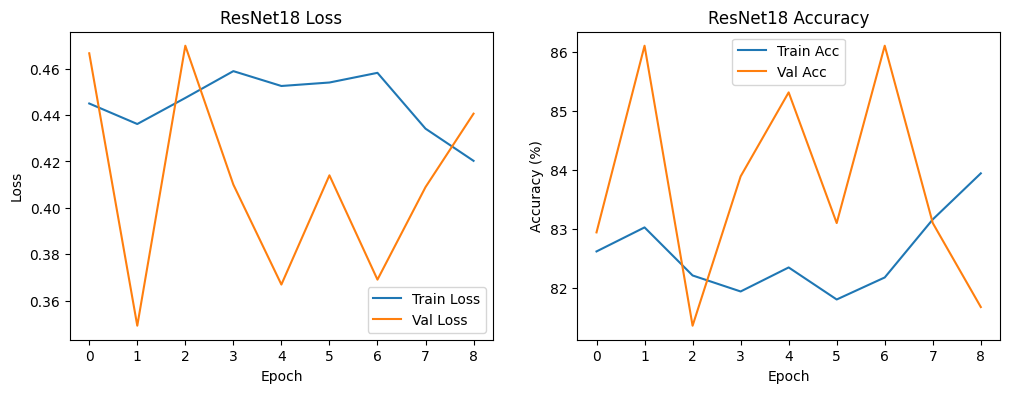

In [38]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
plot_training_history(history, model_name="ResNet18")


Loading best model for testing...
Test Accuracy: 84.20%

Classification Report:

                      precision    recall  f1-score   support

            cataract       0.90      0.93      0.91       156
diabetic_retinopathy       0.89      0.90      0.89       165
            glaucoma       0.87      0.70      0.78       151
              normal       0.73      0.83      0.78       161

            accuracy                           0.84       633
           macro avg       0.85      0.84      0.84       633
        weighted avg       0.85      0.84      0.84       633



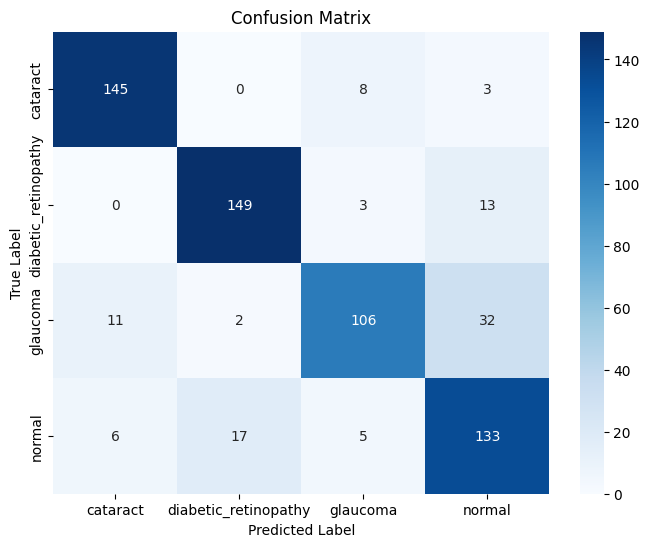

In [39]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the device
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():  # No gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device

            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)  # Total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

            # Collect predictions, labels, and images for later analysis
            all_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU for processing
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU
            all_images.extend(images.cpu())  # Move images to CPU for visualization

    test_acc = 100 * correct / total  # Compute accuracy

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Output results
    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
print("\nLoading best model for testing...")
model2.load_state_dict(torch.load('brain_tumor_resnet18.pth'))
test_model(model2, test_loader)

In [43]:
torch.save(model2.state_dict(), 'eye_disease_model.pth')

In [44]:
from google.colab import files
files.download('eye_disease_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>